In [161]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer, TweetTokenizer 
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

import string
import re

import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stopwords = stopwords.words('english')
#from src.confusion import plot_confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brettzimmerman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [162]:
df = pd.read_csv('phase-4-dataset.csv', encoding= 'latin1')
df


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


# Data Cleaning

Renaming Columns

In [163]:
df.rename(columns={"is_there_an_emotion_directed_at_a_brand_or_product" : "emotion"}, inplace=True)

Adding a label encoder to our target column

In [164]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['emotion'])
df['label'] = le.transform(df['emotion'])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,emotion,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,3
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,3
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,3


In [165]:
df['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

Seeing how many labels we're working with here

In [166]:
df.drop(df[df['label']%2==0].index, inplace = True)

In [167]:
len(df)

3548

## Functions that strip mentions, retweets, and embedded things

In [168]:
#Create a function to clean the Tweets
def remove_junk(text):
    text = re.sub(r'@[A-Za-z0-9#]+', '', str(text)) #remove @mentions 
    text = re.sub(r'RT[\s]+', '', str(text)) # remove RT
    text = re.sub(r'\[VIDEO\]', '', str(text)) # remove [VIDEO] describer
    text = re.sub(r'\{link\}', '', str(text)) # remove {link} describer
    text = re.sub(r'https?:\/\/\S+', '', text) # removes actual links
    text = re.sub(r'#', '', str(text)) # remove hashtag symbol
    text = re.sub(r'&quot', '', str(text)) # remove weird quote symbol
    text = re.sub(r'&amp', '', str(text)) # remove weird and symbol
    
    text = re.sub(r'SXSW', '', str(text)) # remove hashtag symbol
    text = re.sub(r'Android', '', str(text)) # remove hashtag symbol
    text = re.sub(r'iPhone', '', str(text)) # remove hashtag symbol
    text = re.sub(r'Google', '', str(text)) # remove hashtag symbol
    #text = re.sub(r'[^A-Za-z0-9#]', '', str(text)) # remove weird and symbol
    #text = re.sub(r'[\,\.\?\*\$\'\"\!\(\)\:\_\/\-\=\^\;]+', '', text)
    return text



In [175]:
#Create a function that tokenizes text
def tokenize(tweet):
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tokenized_tweet = regex_token.tokenize(tweet)
    #tweet_tokens = [word.lower() for word in tokenized_tweet]
    #cleaned_tweet = [word for word in lowered_tokens if word not in sw]
    return tokenized_tweet

In [176]:
#Create a function that removes stopwords and punctuation 
punctuations = string.punctuation

def remove_sw_punct(tweet_tokens):
    tweets_clean = []
    
    for word in tweet_tokens:
        if (word not in stopwords and word not in punctuations):
            tweets_clean.append(word)
            
    return tweets_clean

In [177]:
stemmer = PorterStemmer()

def stemming(tweets_clean):
    
    
    tweets_stem = [stemmer.stem(token) for token in tweets_clean]
         
    return tweets_stem

In [178]:
#Combining the preprocessing into a function
def process_tweet(text):
    processed_tweet = remove_junk(text)
    tweet_tokens = tokenize(processed_tweet)
    tweets_clean = remove_sw_punct(tweet_tokens)
    tweets_stem = stemming(tweets_clean)
    
    return tweets_clean

In [185]:
#pop 'can't' from stopwords
tweet_example = df['tweet_text'][0]
print(tweet_example)

processed_tweet = process_tweet(tweet_example)
print(processed_tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
['I', 'G', 'iPhone', 'After', 'hrs', 'tweeting', 'RISE', 'Austin', 'dead', 'I', 'need', 'upgrade', 'Plugin', 'stations', 'SXSW']


In [186]:
df['processedtwitter'] = [process_tweet(i) for i in df['tweet_text']]
df['processedtwitter']

0       [I, G, iPhone, After, hrs, tweeting, RISE, Aus...
1       [Know, Awesome, iPad, iPhone, app, likely, app...
2               [Can, wait, iPad, also, They, sale, SXSW]
3       [I, hope, year, festival, crashy, year, iPhone...
4       [great, stuff, Fri, SXSW, Marissa, Mayer, Goog...
                              ...                        
9077    [PR, guy, convinced, switch, back, iPhone, Gre...
9079    [papyrus, sort, like, ipad, nice, Lol, SXSW, L...
9080    [Diller, says, Google, TV, might, run, PlaySta...
9085    [I, always, used, Camera, iPhone, b, c, image,...
9088                             [Ipad, everywhere, SXSW]
Name: processedtwitter, Length: 3548, dtype: object

In [187]:
nltk.pos_tag(processed_tweet)

[('I', 'PRP'),
 ('G', 'VBP'),
 ('iPhone', 'RB'),
 ('After', 'IN'),
 ('hrs', 'NN'),
 ('tweeting', 'VBG'),
 ('RISE', 'NNP'),
 ('Austin', 'NNP'),
 ('dead', 'JJ'),
 ('I', 'PRP'),
 ('need', 'VBP'),
 ('upgrade', 'JJ'),
 ('Plugin', 'NNP'),
 ('stations', 'NNS'),
 ('SXSW', 'NNP')]

In [184]:
df.loc[11]


tweet_text                         Find &amp; Start Impromptu Parties at #SXSW Wi...
emotion_in_tweet_is_directed_at                                          Android App
emotion                                                             Positive emotion
label                                                                              3
processedtwitter                   [Find, Start, Impromptu, Parties, SXSW, With, ...
Name: 11, dtype: object

In [155]:
data_neg = df['processedtwitter'].loc[df['label'] == 1]

negative_sentiment = []
for i in data_neg:
    listToStr = ' '.join(map(str, i))
    negative_sentiment.append(listToStr)
negative_sentiment = ' '.join(map(str,  negative_sentiment))


In [156]:
data_pos = df['processedtwitter'].loc[df['label'] == 3]

positive_sentiment = []
for i in data_neg:
    listToStr = ' '.join(map(str, i))
    positive_sentiment.append(listToStr)
positive_sentiment = ' '.join(map(str,  positive_sentiment))

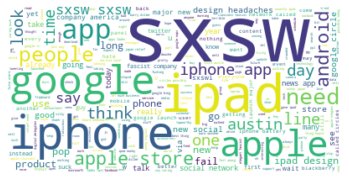

In [157]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data

# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,

)
# generate the word cloud
wc.generate(negative_sentiment)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

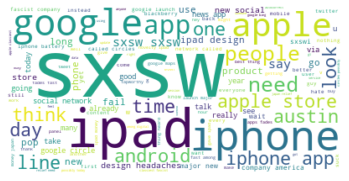

In [158]:
from wordcloud import WordCloud
from PIL import Image # converting images into arrays
import matplotlib.pyplot as plt # for visualizing the data

# instantiate a word cloud object
wc = WordCloud(
    background_color='white',
    max_words=2000,

)
# generate the word cloud
wc.generate(positive_sentiment)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Train Test Split

In [12]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = .9)

### Now to remove all of those @mentions

In [18]:
X_train['clean_tweet'] = X_train['tweet_text'].apply(remove_junk)


In [19]:
X_train['clean_tweet'] = X_train['clean_tweet'].apply(remove_nonASCII)

In [20]:
X_train["clean_tokens"] = X_train["clean_tweet"].apply(tokenize_sw)

In [21]:
#X_train["tweet_text"] = X_train["tweet_text"].str.lower()
#basic_token_pattern = r"(?u)\b\w\w+\b"

#tokenizer = RegexpTokenizer(basic_token_pattern)
#X_train["text_tokenized"] = X_train["tweet_text"].apply(tokenizer.tokenize)

In [22]:
X_train.drop(columns=['clean_tweet'], inplace=True)

In [23]:
X_train

,tweet_text,emotion_in_tweet_is_directed_at,emotion,clean_tokens
7888,So jealous of @mention who is at the team #and...,Android,Positive emotion,"[jealous, team, android, event, sxsw, androids..."
3951,Google's JS implementation of PAC-Man's game l...,Google,Positive emotion,"[googles, js, implementation, pacmans, game, l..."
8997,Data on my iPhone finally sorted. Next stop: #...,iPhone,Positive emotion,"[data, iphone, finally, sorted, next, stop, sxsw]"
8721,Someone just held up iPad with giant LIKE on i...,iPad,Positive emotion,"[someone, held, ipad, giant, like, love, sxsw]"
7356,"Ain't no party like a Google party, cause a Go...",Google,Positive emotion,"[aint, party, like, google, party, cause, goog..."
...,...,...,...,...
5534,RT @mention Awesome hands on review of the iPa...,iPad,Positive emotion,"[awesome, hands, review, ipad, coming, tomorro..."
1282,"Apple Pop Up Store for #SXSW, Why not Pop Up G...",NaN,Positive emotion,"[apple, pop, store, sxsw, pop, genius, bars, e..."
3910,They did it! Unlisted Apple Store suddenly app...,Apple,Positive emotion,"[unlisted, apple, store, suddenly, appears, co..."
968,I can haz one? ÛÏ@mention Just showed off @me...,iPhone,Positive emotion,"[haz, one, showed, charge, anywhere, bar, char..."


In [24]:
from nltk import FreqDist

example_freq_dist = FreqDist(X_train.iloc[100]["clean_tokens"][:20])
example_freq_dist

FreqDist({'android': 1, 'may': 1, 'gaining': 1, 'market': 1, 'share': 1, 'youd': 1, 'never': 1, 'know': 1, 'sxsw': 1, 'apparently': 1, ...})

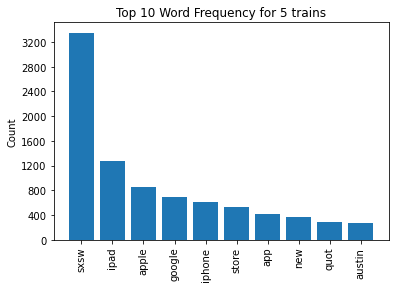

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
train_freq_dist = FreqDist(X_train['clean_tokens'].explode())

# Plot the top 10 tokens
visualize_top_10(train_freq_dist, "Top 10 Word Frequency for 5 trains")

In [26]:
X_train['emotion'].value_counts(normalize=True)

Positive emotion    0.839336
Negative emotion    0.160664
Name: emotion, dtype: float64

In [27]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(
    max_features=20,
    stop_words=sw,
    tokenizer=stem_and_tokenize
)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train['tweet_text'])


# Visually inspect the 10 most common words
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

,amp,android,app,appl,austin,get,googl,ipad,ipad2,iphon,launch,link,mention,new,open,pop,quot,rt,store,sxsw
0,0.000000,0.66999,0.0,0.000000,0.0,0.657004,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.296784,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.177140
1,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.926748,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.375682
2,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.934300,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.356488
3,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.901219,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.433365
4,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.980071,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.198649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.347145,0.0,0.000000,0.0,0.000000,0.839036,0.0,0.000000,0.000000,0.0,0.384244,0.000000,0.166930
3189,0.000000,0.00000,0.0,0.274870,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.893281,0.0,0.000000,0.334932,0.119653
3190,0.519598,0.00000,0.0,0.634543,0.0,0.000000,0.000000,0.287212,0.0,0.000000,0.0,0.276315,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.386599,0.138110
3191,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.599734,0.0,0.000000,0.766782,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.228832


In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.83881064, 0.83881064, 0.83881064, 0.84012539, 0.84012539])

In [29]:
y_train.value_counts(normalize=True)

3    0.839336
1    0.160664
Name: label, dtype: float64